# Overview

In this notebook, we will go through how to implement an image search where the user is able to search images by describing the content of the image and having a model match it with the closest image.

We will be using OpenAI's CLIP model, which was introduced in Redford et al. 2021 [1]. The basic idea of the model is to use contrastive learning to align a vision model and a text model in a unified multi-dimensional space.

[1] https://arxiv.org/pdf/2103.00020.pdf


# Load the Model

Let's start by loading the model. We will be using an open source implementation of the model called [open_clip](https://github.com/mlfoundations/open_clip). This implementation is provided by the [`open_clip_torch` PyPI package](https://pypi.org/project/open-clip-torch/), so you can install it using:

```
pip install open_clip_torch
```

In [1]:
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms('ViT-bigG-14', pretrained='laion2b_s39b_b160k')
model.eval()

CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-47): 48 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): Laye

# Create Images Library

We need a library of images to demonstrate the search capability. This could be your personal photo library, or anything else. For this exercise, however, we will be using images provided with the [`sklearn-image` package](https://scikit-image.org/).

In [2]:
import os
import skimage
from PIL import Image

filenames = [filename
             for filename in os.listdir(skimage.data_dir)
             if filename.endswith(".png") or filename.endswith(".jpg")]
images = [Image.open(os.path.join(skimage.data_dir, filename))
          for filename in filenames]

Let's display the images in our library so we know what we are dealing with:

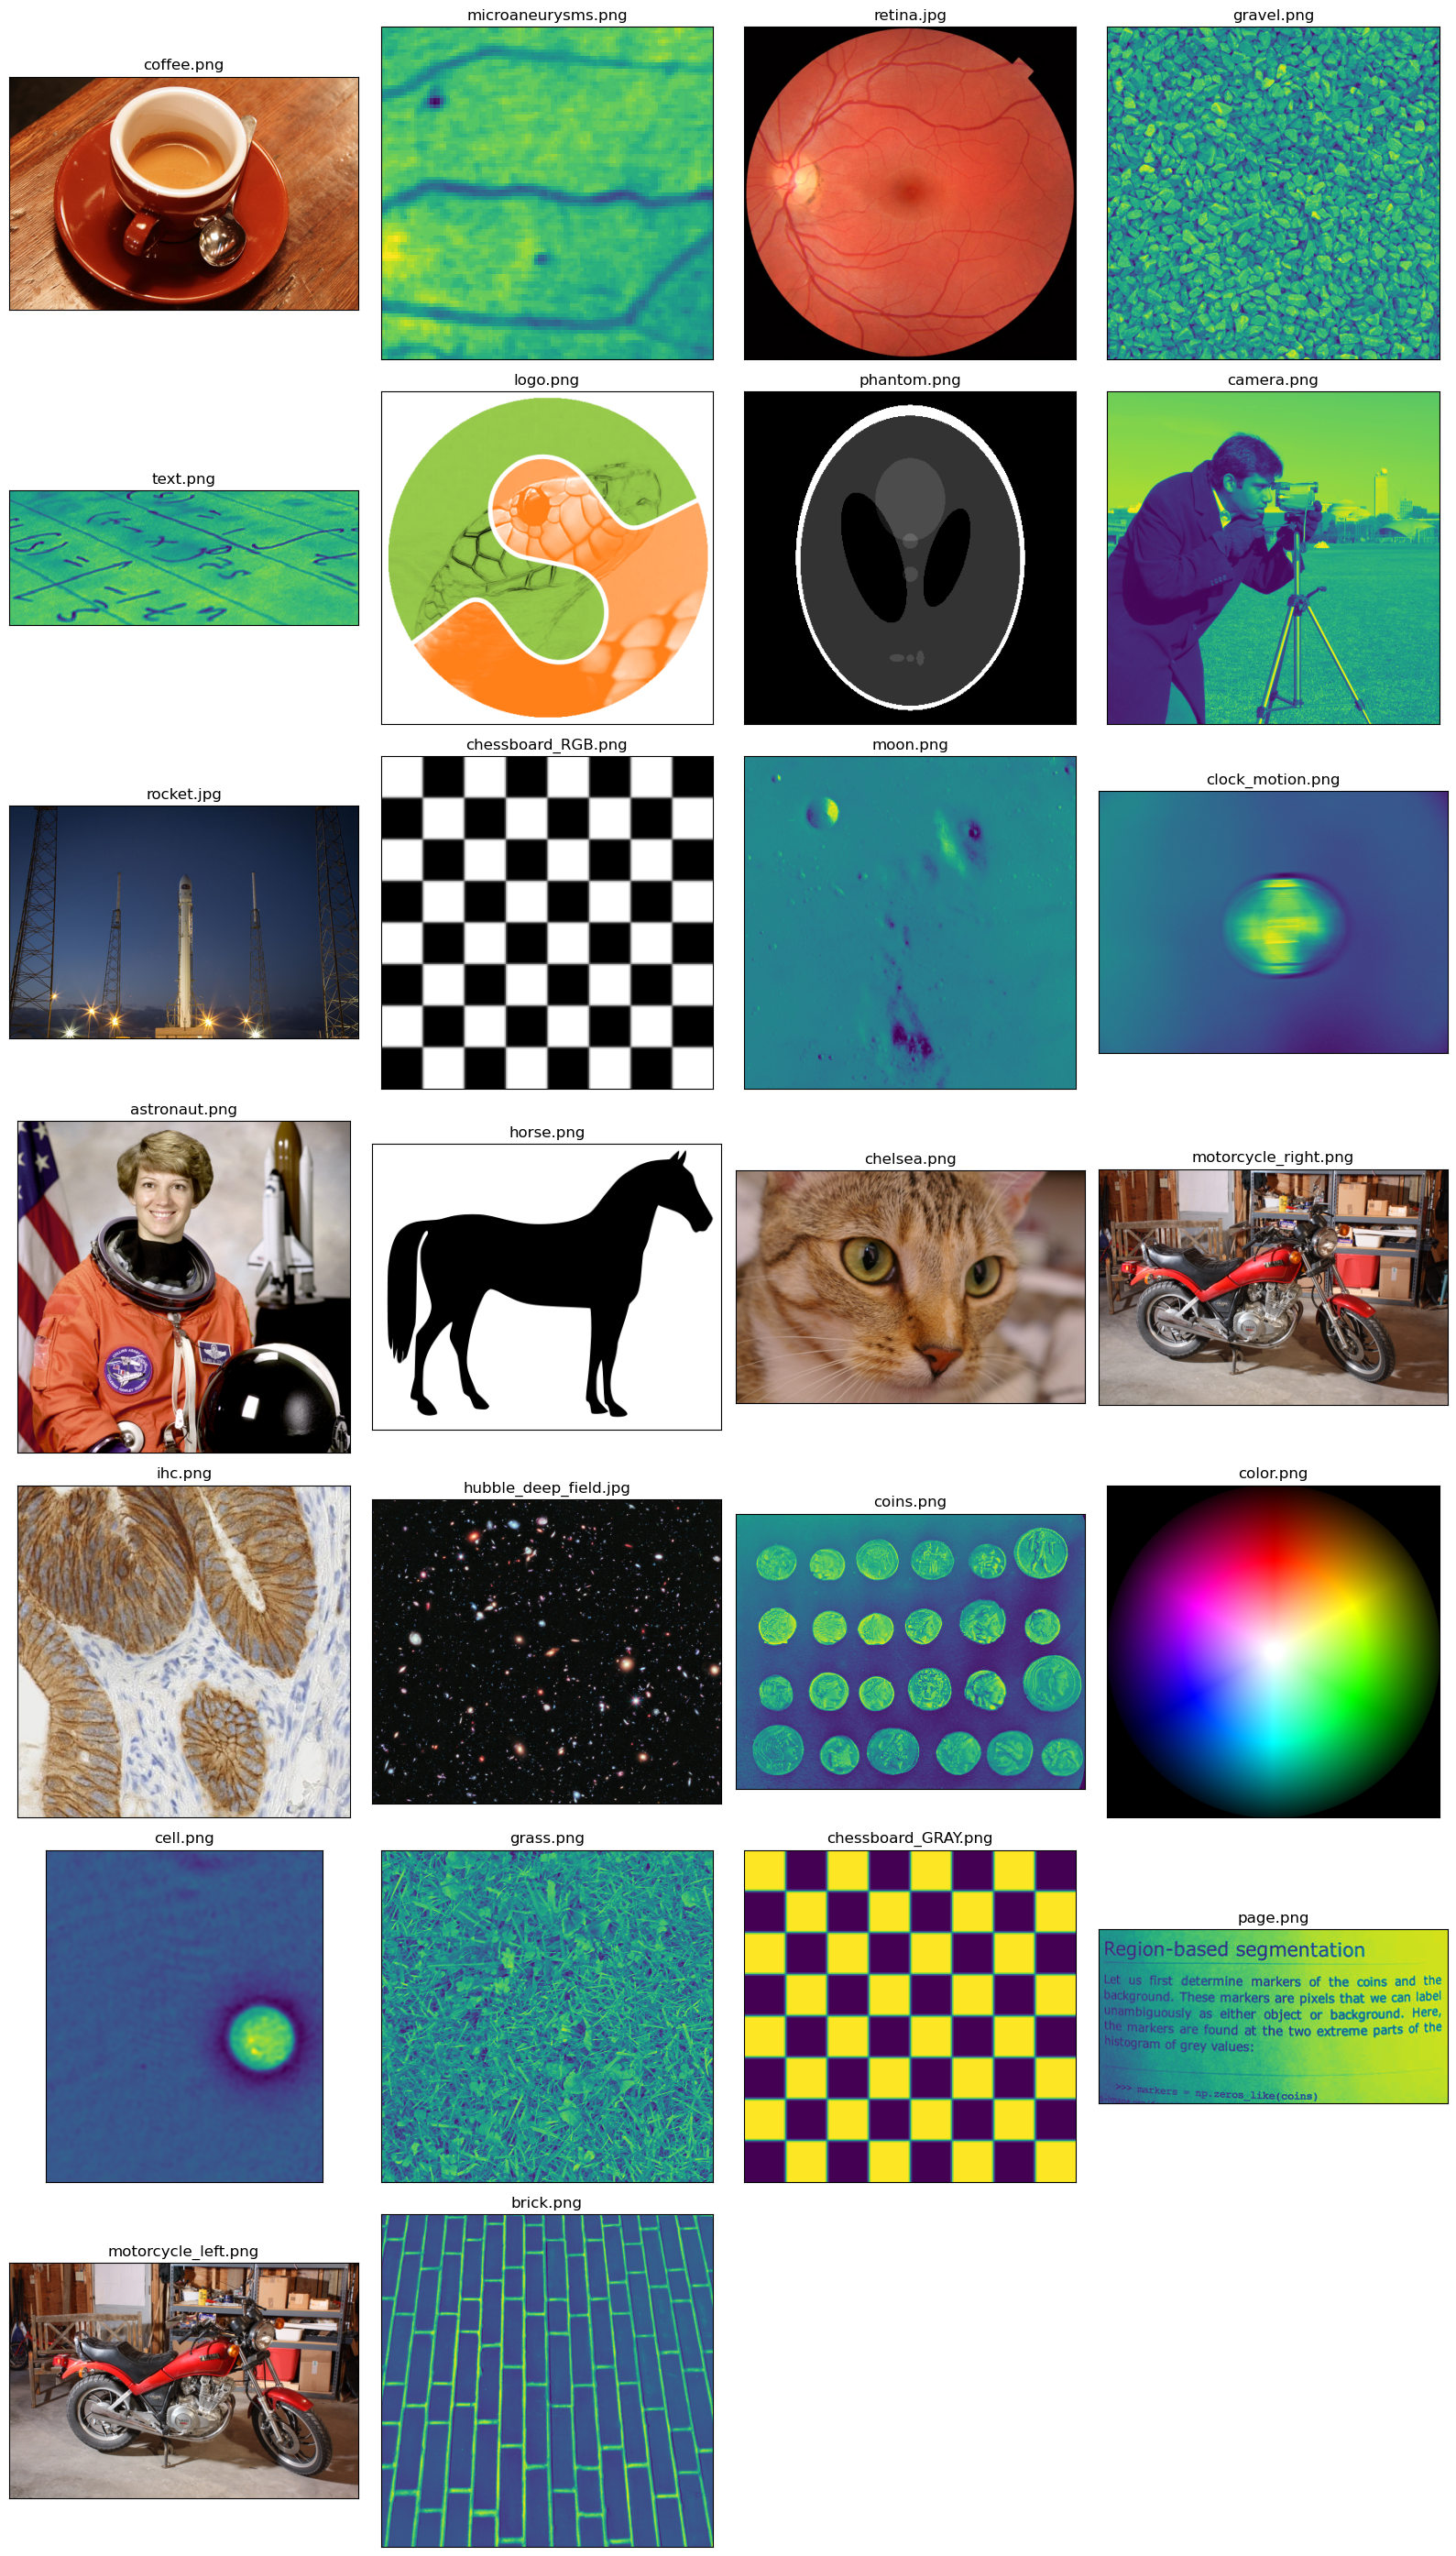

In [3]:
import math
from matplotlib import pyplot as plt


ncols = 4
nrows = math.ceil(len(images) / 4)
plt.figure(figsize=(ncols*4, nrows*4))

for idx, (filename, image) in enumerate(zip(filenames, images)):
    plt.subplot(nrows, ncols, idx+1)
    plt.imshow(image)
    plt.title(filename)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# Features (Embedding) for the Images Library

To be able to search for images in our library, we need to find where they lie in the embedding space, which we will use later when we are given a text query.

In [8]:
import torch

def get_images_features(images):
    preprocessed = [preprocess(image) for image in images]
    with torch.no_grad():
        return model.encode_image(torch.stack(preprocessed), normalize=True)

images_features = get_images_features(images)

Let's inspect the shape of the `images_features` tensor:

In [9]:
images_features.shape

torch.Size([26, 1280])

As expected, its of shape `(N, embedding_dim)`, where `N` is the number of images in our library and `embedding_dim` is the dimension of the embedding space. In this case, it is 1280 since we are using the `ViT-bigG-14` model, which is the [best model trained by open_clip](https://github.com/mlfoundations/open_clip).

# Text Features

Next, we need to build a function for finding the features (embeddings) of a given text. Having the embeggings of the user query and those of the images library, we can find the images that are closest to our query.

In [10]:
from open_clip import tokenizer

def get_text_features(text):
    with torch.no_grad():
        return model.encode_text(tokenizer.tokenize(text), normalize=True)


Let's try this on a some random text:

In [12]:
a = get_text_features('Hello world!')
a, a.shape

(tensor([[ 0.0188,  0.0120, -0.0043,  ..., -0.0319, -0.0355, -0.0031]]),
 torch.Size([1, 1280]))

# Cosine Similarity

To be able to find the closest match to a user query, we need to implement a cosine similarity search feature. Having normalized N-dimensional vectors, the closer the cosine of two vectors is to 1, the closer they are in the N-dimensional space. So, our search problem becomes a problem of finding the cosine similarity of our text query with those of the image library, and showing the images with the top scores.

In [13]:
import numpy as np

def cosine_similarity(image_features, text_features):
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    with torch.no_grad():
        return model.logit_scale.exp() * text_features.cpu() @ image_features.cpu().T

def search_image(query, nresults=3):
    ncols = 4
    nrows = math.ceil(nresults / ncols)
    plt.figure(figsize=(ncols*4, nrows*4))
    similarities = cosine_similarity(
        images_features,
        get_text_features(query)
    )[0].softmax(dim=0)
    result_idxs = similarities.argsort(descending=True)[0:3]

    for idx, result_idx in enumerate(result_idxs):
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(images[result_idx])
        plt.title(similarities[result_idx])
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()

# Experiments

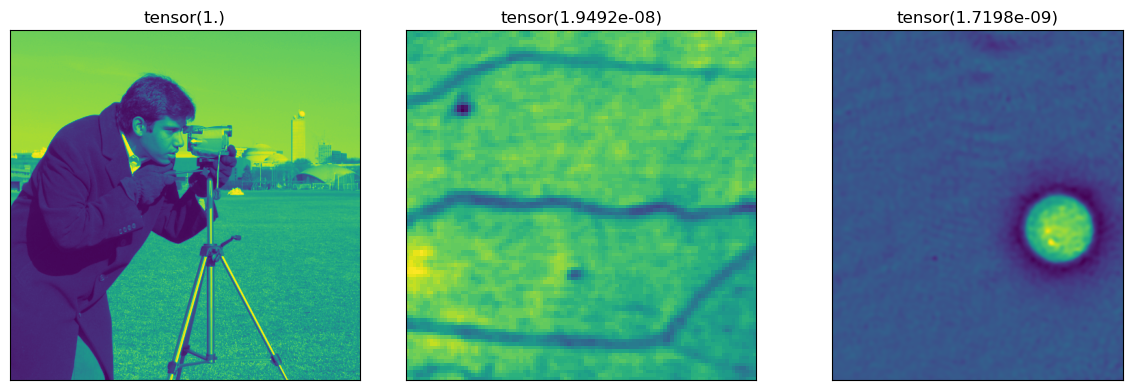

In [14]:
search_image('man with a tripod')

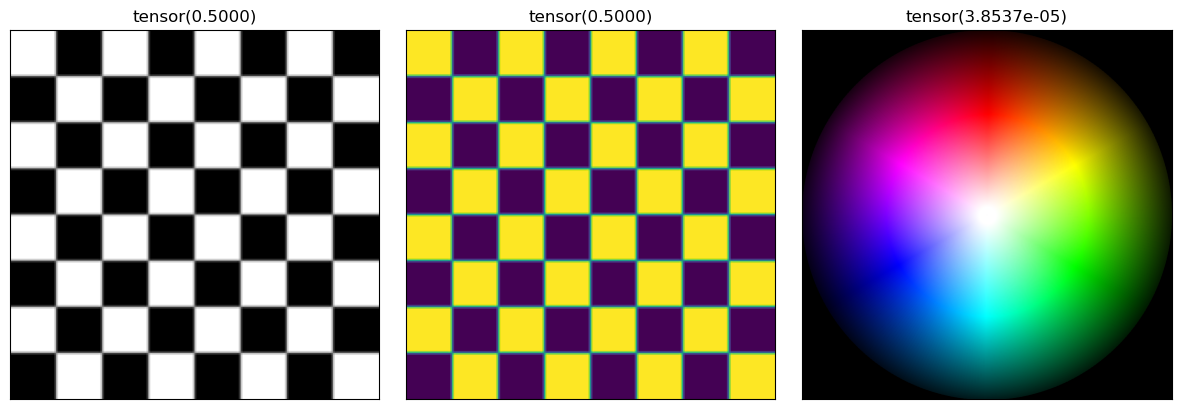

In [15]:

search_image('colored chessboard')

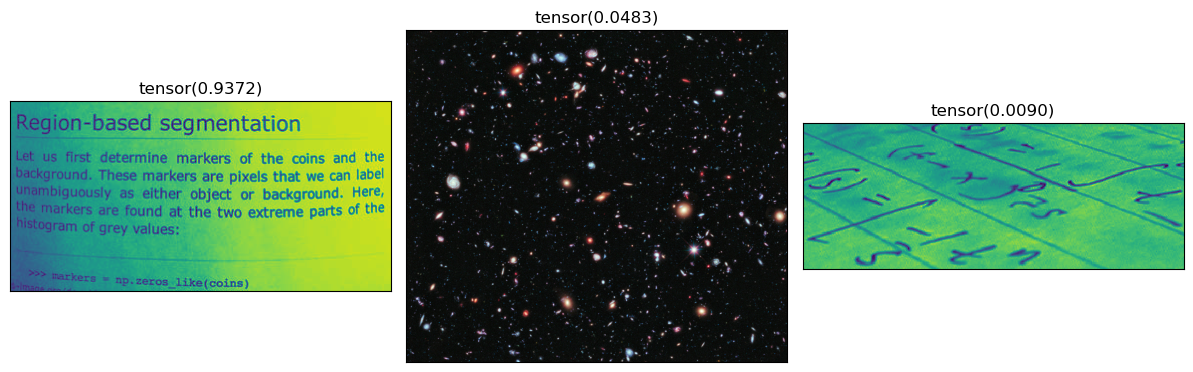

In [16]:

search_image('Text that contains "The US economy is the strongest in the world".')

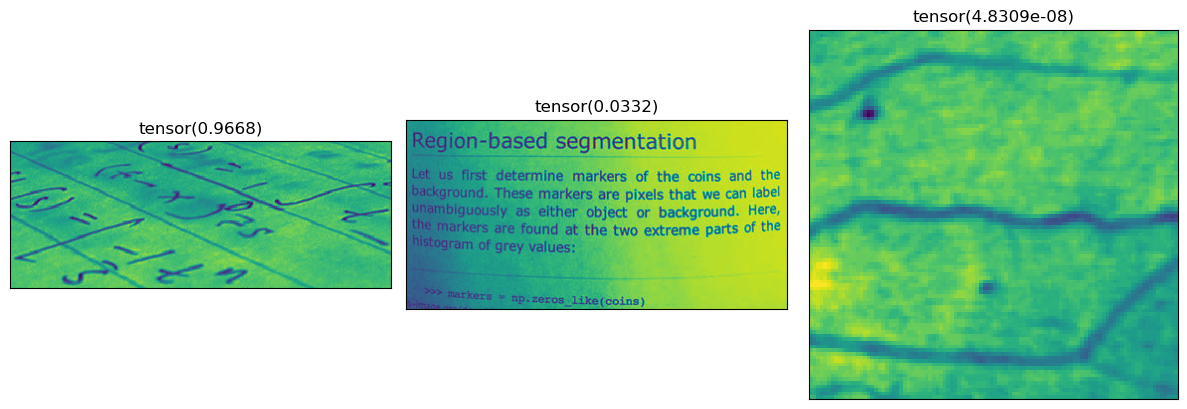

In [17]:
search_image('the text with the math equations')

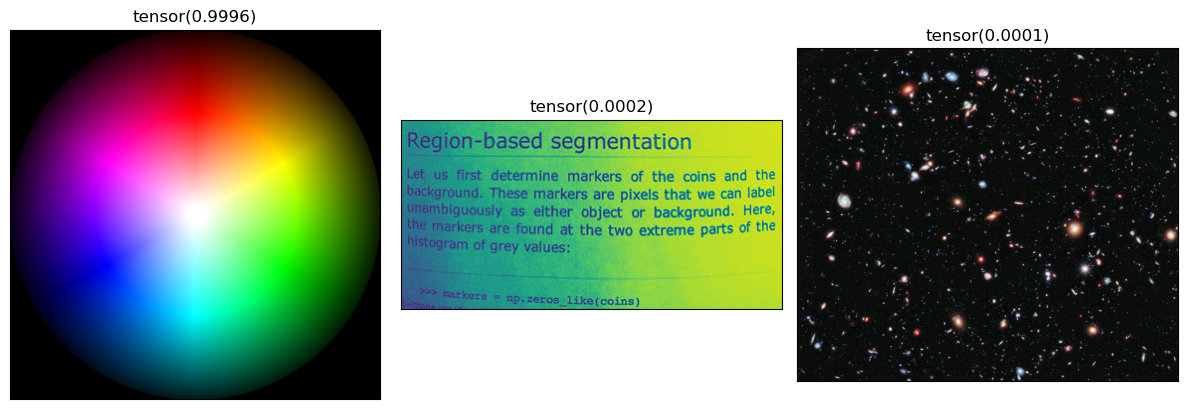

In [18]:
search_image('colors')